In [1]:
# Expand the view to scale with window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

<h1 align="center">
Mixed Finite Element Methods for Elliptic PDEs
</h1>
<h2 align="center">
Adam Morgan
</h2>

This demo borrows heavily from the Firedrake Poisson equation tutorial, available on the web at https://www.firedrakeproject.org/demos/poisson_mixed.py.html . 

## The Problem

Consider a domain $\Omega\subseteq \mathbb{R}^{2}$. In this demo, we study the general Sturm-Liouville PDE, given by

$$
- \nabla \cdot \left( p(x,y)  \ \nabla u \right) + q(x,y) \ u 
= f(x,y). 
$$

The functions $p(x,y), q(x,y),$ and $f(x,y)$ are parameters of the problem. $f(x,y)$ is called the forcing term. The Poisson equation corresponds to the choices $p=1, q=0$. 

For the purposes of this demonstration, we only consider the Dirichlet boundary condition 

$$
u|_{\partial \Omega} = g(x,y).
$$



## Introducing the Mixed Formulation

Now, the PDE above can be recast as a system of PDEs in terms of the scalar field $u$ and the vector field $\boldsymbol{\sigma}$. This system reads

\begin{align}
\boldsymbol{\sigma} -\nabla u &=0
\\ \nabla\cdot\left(p\ \boldsymbol{\sigma}\right) - q \ u &= -f. 
\end{align}

subject to the same BCs (the situation is different if we start with a Neumann boundary condition on $u$, since this translates to a Dirichlet condition on $\sigma$).

We now find a bilinear form $a$ and a linear functional $L$ such that the weak form of the Sturm-Liouville equation can be written as $a=L.$ Denote test functions by $(\boldsymbol{\tau},v)$. Let the outward unit normal on $\partial \Omega$ be denoted by $\mathbf{n}$. Then, define
\begin{align}
a\left((\boldsymbol{\sigma},u),(\boldsymbol{\tau},v)\right) &= \iint_{\Omega} \boldsymbol{\sigma}\cdot \boldsymbol{\tau} + u\nabla\cdot \boldsymbol{\tau} + v \ \nabla\cdot(p\boldsymbol{\sigma}) -quv \ \mathrm{d}x \ \mathrm{d}y, \quad \text{and}
\\ L(\boldsymbol{\tau},v) &= -\iint_{\Omega} fv \ \mathrm{d}A + \oint_{\partial \Omega} g \ \tau\cdot \mathbf{n} \ \mathrm{d} s.
\end{align}
A quick check with integration by parts shows that $a\left((\boldsymbol{\sigma},u),(\boldsymbol{\tau},v)\right)=L(\boldsymbol{\tau},v)$ is indeed the weak form of the Sturm-Liouville equation.

## Function Spaces
We choose $\boldsymbol{\sigma}$ to be in either the order $r$ Raviart-Thomas space, denoted $\mathrm{RT}(r)$, or the order $r$ Brezzi-Douglas-Marini space, denoted $\mathrm{BDM}(r)$. We choose $u$ to be in the order $r-1$ discontinuous Lagrange space, denoted $\mathrm{DG}(r-1)$. Then, the de Rham diagrams 
$$ \mathrm{RT}(r)\xrightarrow{\nabla\cdot}\mathrm{DG}(r-1) \quad \text{and} \quad \mathrm{BDM}(r)\xrightarrow{\nabla\cdot}\mathrm{DG}(r-1)$$
are satisfied. Consequently, finite element exterior calculus (FEEC) guarantees that such a choice of spaces gives an approximation that is consistent with the cohomology of $\Omega$. 

In the code below, I actually give the option to make alternative choices of function spaces that do not respect the requirements of FEEC. You can play with these alternative choices to see that the solutions they give are often quite poor, either not resembling the true solution at all or not resolving the solution very well near the boundary. 

## Some Remarks on the Theory
In the main thesis, I did not discuss stability and convergence at all, even for important problems like the Poisson equation. However, FEEC provides an elegant framework for studying stability and convergence, as demonstrated in the 2010 paper of Arnold, Falk, and Winther (available at https://arxiv.org/pdf/0906.4325.pdf). In Sections 3.2 and 3.4 of this paper, the authors show that the mixed formulation of the Poisson equation on $k$-forms (a special case of the method derived above for the general Sturm-Liouville PDE) is well-posed and converges to the exact solution, provided the finite element spaces are chosen according to the demands of FEEC. 

Note that the problem we consider here is more properly phrased as a PDE for the coefficient function $u$ of a $2$-form, rather than a scalar function. This is because we want the exterior derivative on $\sigma$ to correspond with the divergence and the exterior coderivative on $u$ to correspond with the gradient. Since the space of harmonic $2$-forms on a dimensional domain in $\mathbb{R}^2$ is trivial, we do not have to worry about demanding that the forcing term and solution are orthogonal to the harmonic forms in order to obtain good numerical solutions. In general, however, one must be careful to 

## Implementation in Firedrake

In [2]:
# Import libraries

from firedrake import *
import numpy as np                      
import matplotlib.pyplot as plt

In [3]:
Lx, Ly = 1.0, 1.0

n   = 100
mesh = RectangleMesh(n, n, Lx, Ly,  reorder = None) 

x,y = SpatialCoordinate(mesh)

Now, we come to inputting our choices of finite element spaces. Fortunately, Firedrake makes this very easy. I provide four possible choices of function spaces in order for the user to see that choosing spaces with FEEC in mind often gives unambiguously nicer results. 

Choosing SpaceChoice = 1 or 2 gives us spaces that respect the FEEC requirements discussed in Chapter 9 of the thesis. The numerical solutions they yield are similar to one another and, after the 2010 paper of Arnold et al. discussed above, we can expect these solutions to be close to the exact solution.

Choosing SpaceChoice = 3 or 4, conversely, gives messy solutions. These choices do not conform to FEEC requirements. For SpaceChoice =3, the finite element family is right but the degrees of the polynomials do not match up to give a subcomplex of the de Rham complex. For SpaceChoice =4, we've used an approximating space for $\sigma$ that is not on the periodic table at all, consisting of vector fields whose entries are globally continuous piecewise degree $1$ polynomials. 

I would like to remark on how easily we can input a choice of finite element spaces in Firedrake: the software contains a catalogue of common spaces, and we just input whatever ones we want. So, there really is no excuse not to use a FEEC-inspired method, as such a method is just as easy to code up as a more naïve "bad" method. 

In [4]:
SpaceChoice = 1

if SpaceChoice == 1:
    
    # Good Choice of Function Spaces 1
    # Here, we use the trimmed family, so we have to choose spaces 
    # by going horizontally in the first column of the periodic table. 
    deg = 1 

    Vparam = FunctionSpace(mesh, "CG", deg) #Use vparam to ensure that div(p sigma) exists. 

    Vvect = FunctionSpace(mesh, "RT", deg) # Space where sigma lives, chosen to be RT(deg)
    Vscal = FunctionSpace(mesh, "DG", deg-1) # Space where u lives, chosen to be DG(deg-1)
    V = MixedFunctionSpace([Vvect,Vscal])
    
elif SpaceChoice == 2:
    
    # Good Choice of Function Spaces 2
    # Here, we use the regular family, so we have to choose spaces 
    # by going diagonally in the second column of the periodic table. 
    deg = 1 

    Vparam = FunctionSpace(mesh, "CG", deg) #Use vparam to ensure that div(p sigma) exists. 

    Vvect = FunctionSpace(mesh, "BDM", deg) # Space where sigma lives, chosen to be BDM(deg)
    Vscal = FunctionSpace(mesh, "DG", deg-1) # Space where u lives, chosen to be DG(deg-1)
    V = MixedFunctionSpace([Vvect,Vscal])
    
elif SpaceChoice == 3:

    # Bad Choice of Function Spaces 1
    # Running this choice gives a solution that does not at all resemble the (correct) solution 
    # predicted by the first two function space choices. 

    deg = 1 

    Vparam = FunctionSpace(mesh, "CG", deg) #Use vparam to ensure that div(p sigma) exists. 

    Vvect = FunctionSpace(mesh, "RT", deg+1) # Space where sigma lives, chosen to be RT(deg+1)
    Vscal = FunctionSpace(mesh, "DG", deg-1) # Space where u lives, chosen to be DG(deg-1)
    V = MixedFunctionSpace([Vvect,Vscal])
 
elif SpaceChoice == 4:

    # Bad Choice of Function Spaces 2
    # This choice gives a messy, jagged solution that jumps around too much. 
    # The resolution of the solution near the boundary is especially poor. 

    deg = 1 

    Vparam = FunctionSpace(mesh, "CG", deg) #Use vparam to ensure that div(p sigma) exists. 

    Vvect = VectorFunctionSpace(mesh, "CG", deg) # Space where sigma lives, chosen to be CG(deg) \oplus CG(deg)
    Vscal = FunctionSpace(mesh, "DG", deg-1) # Space where u lives, chosen to be DG(deg-1)
    V = MixedFunctionSpace([Vvect,Vscal])

else:
    
    print('User must choose finite element spaces.')
    sys.exit()

Now, we specify the functions $g,\  f,\  p$, and $q$. The default choices are

\begin{align}
g(x,y) &= x,
\\ \\ f(x,y) &= 30 \ e^{-50\left[\left(x-\frac12\right)^2 + \left(y-\frac12\right)^2\right]},
\\ \\ p(x,y) &=1, \quad \text{and}
\\ \\ q(x,y) &= 25(1+x).
\end{align}

In [5]:
# Specify Dirichlet boundary conditions

g=interpolate(Expression("x[0]"),Vscal)
bcs = DirichletBC(V.sub(1), g, "on_boundary", method="geometric")

In [6]:
# Functions
f = Function(Vscal)
p = Function(Vparam)
q = Function(Vparam)

f.interpolate(Expression("30.*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)"));
#f.interpolate(Expression("-4.0+x[0]*x[0]*x[0]*x[1]+x[1]*x[1]*x[0]*x[1]"));

#p.interpolate(Expression(" 1.0 - 0.3*pow(x[0]*x[1],2)"));
p.interpolate(Expression("1.0"));

#q.interpolate(Expression("x[0]*x[1]"));
q.interpolate(Expression(" 25.0 + 25.0*x[0]"));



In [7]:
# Define weak form 
tau, v = TestFunctions(V)
sigma, u = TrialFunctions(V)

K= FacetNormal(mesh)

a = (dot(sigma,tau) + u * div(tau)+v * div(p * sigma) - q * u * v) * dx 
L = (-f * v) * dx + (g*dot(K,tau)) *ds

# Notice how different commands (dx or ds)  have been used to select whether the integral 
# is taken over the domain or the boundary

The choices of solver parameters applied below are inspired by 

https://www.firedrakeproject.org/demos/saddle_point_systems.py.html . 

Numerical linear algebra is actually a big issue: the wrong solver parameters will 
decouple the BCs from the internal solution (for example, try ksptype=preonly for a "good" choice of spaces). Note that, for some of the "bad" choices, you may have to comment out the "solver_parameters" to get the routine to converge. 

In [8]:
soln = Function(V)
sigmah, uh = soln.split() #Break into components for plotting

solve(a == L, soln, bcs = bcs
,solver_parameters = {
    "ksp_type": "fgmres",
    "ksp_rtol": 1e-8})

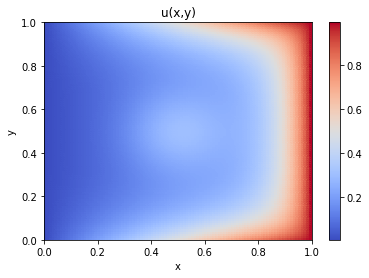

In [9]:
# PLOT SOLUTION
plot(uh)
plt.xlabel('x')
plt.ylabel('y')
plt.title('u(x,y)')
plt.xlim([0,Lx])
plt.ylim([0,Ly])
plt.show()

After playing around with the "good" (SpaceChoice=1 and 2) and "bad" (SpaceChoice=3 and 4) choices, one can see that choosing approximating spaces contributes a great deal to the success or failure of a numerical method. In particular, we don't always have a lot of wiggle room to choose spaces outside of the FEEC formalism (SpaceChoice=3 demonstrates this very clearly). Though the failures of the "bad" choices are not nearly as dramatic as those discussed in the 2010 paper of Arnold, Falk and Winther, they still mean that we can't really use such choices to make reliable quantitative predictions with this solver. 